In [192]:
###
###  Deconvolution is the "inverse" of convolution.
###  But the output shape may be anbigious upto 1 cell depend on padding.
###
import os
tf.reset_default_graph()

CH=2
RATE=4096
BATCH = 5
#x  = tf.constant(1.0, shape=[ 1,RATE,CH])
#e1 = tf.constant(1.0, shape=[16, CH, 16]  )   ##filter_height, filter_width, in_channels, out_channels]
#e2 = tf.constant(1.0, shape=[ 8, 16, 32]  )
#e3 = tf.constant(1.0, shape=[ 8, 32, 64]  )
#d1 = tf.constant(1.0, shape=e1.shape   )
#d2 = tf.constant(1.0, shape=e2.shape   )
#d3 = tf.constant(1.0, shape=e3.shape   )

beta = tf.placeholder(tf.float32, shape=(None) )
#x  = tf.constant(1.0, shape=[ ,RATE,CH])
x = tf.placeholder(tf.float32, shape=(None, CH, RATE))
print(x)
we1 = tf.Variable(tf.truncated_normal( shape=[16, CH, 16], stddev=0.1), dtype=tf.float32 )
we2 = tf.Variable(tf.truncated_normal( shape=[ 8, 16, 32], stddev=0.1), dtype=tf.float32 )
we3 = tf.Variable(tf.truncated_normal( shape=[ 8, 32, 64], stddev=0.1), dtype=tf.float32 )
wd1 = tf.Variable(tf.truncated_normal( shape=e1.shape,     stddev=0.1), dtype=tf.float32 )
wd2 = tf.Variable(tf.truncated_normal( shape=e2.shape,     stddev=0.1), dtype=tf.float32 )
wd3 = tf.Variable(tf.truncated_normal( shape=e3.shape,     stddev=0.1), dtype=tf.float32 )

h1 = tf.nn.conv1d(x,  we1, stride=4, padding="SAME", data_format="NCW")  ##(1, 1024, 16)
print(h1)
h2 = tf.nn.conv1d(h1, we2, stride=4, padding="SAME", data_format="NCW")  ##(1, 256, 32)
print(h2)
h3 = tf.nn.conv1d(h2, we3, stride=4, padding="SAME", data_format="NCW")  ##(1, 64, 64)
print(h3)

h3 = tf.reshape(h3, [-1, 64*64])
h4 = tf.layers.dense(h3, 64, activation=tf.nn.relu)
we4 = tf.get_default_graph().get_tensor_by_name( os.path.split(h4.name)[0] + '/kernel:0')
be4 = tf.get_default_graph().get_tensor_by_name( os.path.split(h4.name)[0] + '/bias:0')
print(we4)
print(be4)

bn = tf.layers.dense(h4,  2, activation=tf.nn.relu)  ### bottlenet
wd5 = tf.get_default_graph().get_tensor_by_name( os.path.split(bn.name)[0] + '/kernel:0')
bd5 = tf.get_default_graph().get_tensor_by_name( os.path.split(bn.name)[0] + '/bias:0')
print(wd5)
print(bd5)

g4  = tf.layers.dense(bn,    64, activation=tf.nn.relu)

g4  = tf.layers.dense(g4, 64*64, activation=tf.nn.relu)
wd4 = tf.get_default_graph().get_tensor_by_name( os.path.split(g4.name)[0] + '/kernel:0')
bd4 = tf.get_default_graph().get_tensor_by_name( os.path.split(g4.name)[0] + '/bias:0')
print(wd4)
print(bd4)

g3  = tf.reshape(g4, [-1, 64, 64])
g2  = tf.contrib.nn.conv1d_transpose(g3, wd3, stride=4, output_shape=[BATCH,  256, 32], padding="SAME", data_format="NCW")
g1  = tf.contrib.nn.conv1d_transpose(g2, wd2, stride=4, output_shape=[BATCH, 1024, 16], padding="SAME", data_format="NCW")
out = tf.contrib.nn.conv1d_transpose(g1, wd1, stride=4, output_shape=[BATCH, RATE, CH], padding="SAME", data_format="NCW")

train_vars = [we1,we2,we3,we4, wd1,wd2,wd3,wd4, be4,bd4]
regularizer =   tf.reduce_sum( [ tf.reduce_sum( tf.pow(w,2)/(1+tf.pow(w,2)))    for w in train_vars ] )    \
              / tf.reduce_sum( [ tf.size(w,out_type=tf.float32)                 for w in train_vars ] )    

#loss = tf.reduce_mean(beta * regularizers)
loss = beta * regularizer
#loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=out) )
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, x ))

data = np.random.random([BATCH, RATE, CH])
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  #sess.run(out)
  print( sess.run(loss, feed_dict={beta: 1, x: data} ) )


Tensor("Placeholder_1:0", shape=(?, 2, 4096), dtype=float32)
Tensor("conv1d/Squeeze:0", shape=(?, 16, 1024), dtype=float32)
Tensor("conv1d_1/Squeeze:0", shape=(?, 32, 256), dtype=float32)
Tensor("conv1d_2/Squeeze:0", shape=(?, 64, 64), dtype=float32)
Tensor("dense/kernel:0", shape=(4096, 64), dtype=float32_ref)
Tensor("dense/bias:0", shape=(64,), dtype=float32_ref)
Tensor("dense_1/kernel:0", shape=(64, 2), dtype=float32_ref)
Tensor("dense_1/bias:0", shape=(2,), dtype=float32_ref)
Tensor("dense_3/kernel:0", shape=(64, 4096), dtype=float32_ref)
Tensor("dense_3/bias:0", shape=(4096,), dtype=float32_ref)


ValueError: output_shape does not match filter's output channels, 256 != 32

In [2]:
############################################################
### Project: Autoencoder with hidden layer constrained
############################################################

#### Prepare env
from __future__ import print_function
import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.client import device_lib
print ([x.name for x in device_lib.list_local_devices()] )

tf.reset_default_graph()


/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Numpy      ver.  1.15.4
Numba      ver.  0.41.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.12.0
[u'/device:CPU:0', u'/device:XLA_GPU:0', u'/device:XLA_CPU:0', u'/device:GPU:0', u'/device:GPU:1']


In [3]:
#### Load waveform data

H5_FILE="white_h_8192_dm2.h5"
RATE=8192
H5_FILE="white_h_4096_dm2.h5"
RATE=4096
#H5_FILE="white_h_4096_dm1.h5"
#RATE=4096

#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_4096_dm2.h5
#!ls


/home/lincy/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# of whiten waveform for each set:  685


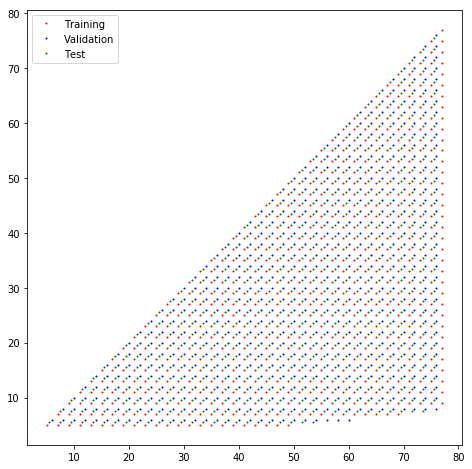

In [4]:
#### Now, visualize the dataset 

import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

f = h5.File(H5_FILE,'r')
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(8,8))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
#plt.show()
plt.savefig("VAE_tpl.png")

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

In [5]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split


from sklearn.utils import shuffle

_NOISE_COPY_ = 1
class GWInject():
    def _add_noise(self, tag, A, nc):
        var = self.f[tag]
        NX = len(var)
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')   ##4096/ 8192
        print(self.srate, self.f.attrs.get('merger_idx'))
        
    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc)
        return X, Y
    def get_val_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc)
        return X, Y
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test_hp', A, nc = _NOISE_COPY_)
        return X, Y

      
    def getdata(self, tag='/train', A=1.0):
        X1 = A*np.array(self.f[tag+'_hp'])  #.astype(np.float32)
        X2 = A*np.array(self.f[tag+'_hc'])  #.astype(np.float32)
        Y  = np.vstack(( self.f[tag+'_m1'],self.f[tag+'_m2'] )).astype(np.float32)
        
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X1)):
                plt.subplot(3,5,i+1)         
                plt.plot(X1[i,:])
                plt.title("m=(%.1f, %.1f)"%(Y[0,i],Y[1,i]))
                plt.xticks([])
                if (i > 13): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
        #return np.hstack((X1, X2)), Y
    
#tmp = GWInject(H5_FILE, plot=0)
AMP = 0.7
#X,Y,_ = tmp.getdata('/train', A=AMP)  
#print(X.shape)
#print(X.shape)
#tmp.__exit__()

In [6]:
### Main autoencoder:  See https://www.ycc.idv.tw/tensorflow-tutorial_4.html
import random

RATE = 4096
HIDDEN = 2
CH = [2,16,32,64]
CH = [2,8,16,32]
K  = [16,8,8]
K  = [8,4,4]

class Autoencoder(object):
    def __init__(self,learning_rate=0.5, alpha=0.0):

        self.weights = None
        self.biases = None
        self._batch = None

        self.graph = tf.Graph() # initialize new grap
        self.build(learning_rate, alpha) # building graph
        
        # Config to turn on JIT compilation
        config = tf.ConfigProto()
        config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
        self.sess = tf.Session(config=config, graph=self.graph) # create session by the graph 
        
        #summary_writer.add_graph(self.graph)

            
    def build(self,learning_rate, alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None, CH[0], RATE))
            self.train_targets  = tf.placeholder(tf.float32, shape=(None, HIDDEN))   ### for "constraint" hidden
            self.latent         = tf.placeholder(tf.float32, shape=(None, HIDDEN))
            self._batch         = tf.placeholder(tf.int32, shape=(None))
            
            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure( X=self.train_features, Y=self.train_targets )

            # regularization loss
            # weight elimination L2 regularizer
            #self.regularizer =   tf.reduce_sum( [ tf.reduce_sum( tf.pow(w,2) )    for w in self.weights ] )    \
            #                   / tf.reduce_sum( [ tf.size(w, out_type=tf.float32)  for w in self.weights ] )    
            self.regularizer =   tf.reduce_sum( [ tf.reduce_sum( tf.pow(w,2) / (1 + tf.pow(w,2)) )    for w in self.weights ] )    \
                               / tf.reduce_sum( [ tf.size(w, out_type=tf.float32)                 for w in self.weights ] )    

            # total loss
            self.loss = self.original_loss + alpha * self.regularizer

            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None, CH[0], RATE))
            self.new_targets  = tf.placeholder(tf.float32, shape=(None, HIDDEN))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(X=self.new_features, Y=self.new_targets)  
            self.new_loss = self.new_original_loss + alpha * self.regularizer

            ### genwf
            
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  

    def genwf(self, latent):

        out = self.generator(latent)

        return self.sess.run(out, feed_dict={self.latent : latent, self._batch: latent.shape[0] })
      
    def generator(self, latent):

        fclact = tf.math.atan
        fclact = tf.nn.relu
        fclact = tf.nn.sigmoid
        g4      = self.getDenseLayer(latent, self.weights[5], self.biases[5], activation=tf.nn.sigmoid)
        g4      = self.getDenseLayer(g4,     self.weights[6], self.biases[6], activation=tf.nn.relu)

        g3  = tf.reshape(g4, [-1, CH[3], 64 ])
        g2  = tf.contrib.nn.conv1d_transpose(g3, self.weights[7], stride=4, output_shape=[self._batch,  CH[2], 256], padding="SAME", data_format="NCW")
        g2 = tf.math.atan(g2)
        g1  = tf.contrib.nn.conv1d_transpose(g2, self.weights[8], stride=4, output_shape=[self._batch,  CH[1], 1024], padding="SAME", data_format="NCW")
        
        g1 = tf.math.atan(g1)
        out = tf.contrib.nn.conv1d_transpose(g1, self.weights[9], stride=4, output_shape=[self._batch, CH[0], RATE], padding="SAME", data_format="NCW")
        out = tf.math.atan(out)

        return out
      
    def structure(self, X, Y):
        ### Variable
        if (not self.weights) and (not self.biases):
            ###################
            IDEV = 0.1

            we1 = tf.Variable(tf.truncated_normal( shape=[ K[0], CH[0], CH[1] ], stddev=IDEV), dtype=tf.float32 ) ##(?, 1024, 16)
            we2 = tf.Variable(tf.truncated_normal( shape=[ K[1], CH[1], CH[2] ], stddev=IDEV), dtype=tf.float32 ) ##(?,  256, 32)
            we3 = tf.Variable(tf.truncated_normal( shape=[ K[2], CH[2], CH[3] ], stddev=IDEV), dtype=tf.float32 ) ##(?,   64, 64)
            
            wef1 = tf.Variable(tf.truncated_normal( shape=[  CH[3]*64,  256 ], stddev=IDEV), dtype=tf.float32 )
            wef2 = tf.Variable(tf.truncated_normal( shape=[       256,    2 ], stddev=IDEV), dtype=tf.float32 )
            wdf2 = tf.Variable(tf.truncated_normal( shape=[         2,  256 ], stddev=IDEV), dtype=tf.float32 )
            wdf1 = tf.Variable(tf.truncated_normal( shape=[       256, CH[3]*64 ], stddev=IDEV), dtype=tf.float32 )
            bef1 = tf.Variable(tf.zeros( shape=[  256 ]), dtype=tf.float32 )
            bef2 = tf.Variable(tf.zeros( shape=[    2 ]), dtype=tf.float32 )
            bdf2 = tf.Variable(tf.zeros( shape=[  256 ]), dtype=tf.float32 )
            bdf1 = tf.Variable(tf.zeros( shape=[ CH[3]*64 ]), dtype=tf.float32 )

            wd3 = tf.Variable(tf.truncated_normal( shape=we3.shape,     stddev=IDEV), dtype=tf.float32 )
            wd2 = tf.Variable(tf.truncated_normal( shape=we2.shape,     stddev=IDEV), dtype=tf.float32 )
            wd1 = tf.Variable(tf.truncated_normal( shape=we1.shape,     stddev=IDEV), dtype=tf.float32 )
            
            self.weights = [ we1, we2, we3, wef1, wef2, wdf2, wdf1, wd3, wd2, wd1 ]
            #self.weights = [ we1, we2, we3, wef1, wef2, wdf2, wdf1, we3, we2, we1 ]
            self.biases  = [   0,   0,   0, bef1, bef2, bdf2, bdf1                ]

        h1 = tf.nn.conv1d(X,  self.weights[0], stride=4, padding="SAME", data_format="NCW") ##(1, 1024, 16)
        h1 = tf.math.atan(h1)
        h2 = tf.nn.conv1d(h1, self.weights[1], stride=4, padding="SAME", data_format="NCW") ##(1, 256, 32)
        h2 = tf.math.atan(h2)
        h3 = tf.nn.conv1d(h2, self.weights[2], stride=4, padding="SAME", data_format="NCW") ##(1, 64, 64)
        h3 = tf.math.atan(h3)
        
        fclact = tf.math.atan
        fclact = tf.nn.relu
        fclact = tf.nn.sigmoid
        h3      = tf.reshape(h3, [-1,  CH[3]*64 ] )
        h4      = self.getDenseLayer(h3, self.weights[3], self.biases[3], activation=tf.nn.sigmoid)
        encoder = self.getDenseLayer(h4, self.weights[4], self.biases[4], activation=None)
        #print(encoder)
        
        decoder = self.generator(encoder)

        #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=decoder) +  tf.reduce_mean(tf.pow(Y- encoder, 2))
        loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=decoder) ) #+ tf.reduce_mean(tf.pow(Y - encoder, 2))
        print ("DE  ", decoder)
        print ("Loss",  tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=decoder))
        #loss = tf.reduce_mean(tf.pow(X - decoder, 2)) + tf.reduce_mean(tf.pow(Y - encoder, 2))

        return (decoder,loss,encoder)

    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x


    def fit(self,X,Y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        print("Batch_size = ", batch_size)
            
        self.sess.run(self.init_op)
        start_time = time.time()
        for epoch in range(epochs):
            #if epoch%1==0:   print("Epoch %2d/%2d: "%(epoch+1,epochs))

            # mini-batch gradient descent
            index = [i for i in range(N)]   #random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]
                merged = tf.summary.merge_all()
                #print("idx ...  ", batch_index)

                feed_dict = {self.train_features: X[batch_index,:],
                             self.train_targets:  Y[batch_index,:], self._batch: len(batch_index) }
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                #_, loss, merged0 = self.sess.run([self.train_op, self.loss, merged], feed_dict=feed_dict)

                ##if epoch%100==0: print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')
                ##summary_writer.add_summary(merged0, epoch)

            # evaluate at the end of this epoch
            val_loss = 0
            if validation_data is not None: val_loss = self.evaluate(validation_data[0],validation_data[1])

            train_loss = self.evaluate(X,Y)
            if epoch%10==0: print("[%5d] %5ds tloss = %9.4f   vloss = %9.4f" % ( epoch, (time.time()-start_time), train_loss, val_loss ))

        if test_data is not None:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))

    #def encode(self,X):
    #    X = self._check_array(X)
    #    return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})

    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X, self._batch: X.shape[0]})

    def evaluate(self,X,Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X, self.new_targets: Y, self._batch: X.shape[0]} )

    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray

In [7]:
### Training 

tmp = GWInject(H5_FILE, plot=0)
Xt1,Xt2,Yt = tmp.getdata('/train', A=AMP)  
Xv1,Xv2,Yv = tmp.getdata('/val', A=AMP)  
Xs1,Xs2,Ys = tmp.getdata('/test', A=AMP)  
Xt = np.reshape( np.hstack((Xt1,Xt2)), (-1, CH[0], RATE) )
Xv = np.reshape( np.hstack((Xv1,Xv2)), (-1, CH[0], RATE) )
Xs = np.reshape( np.hstack((Xs1,Xs2)), (-1, CH[0], RATE) )
print (Xt.shape)
print (Xv.shape)
print (Xs.shape)
print (Yt.shape)
print (Yv.shape)
print (Ys.shape)

model_1 = Autoencoder( learning_rate = 0.005, alpha=0.001 )

model_1.fit(X=Xt, Y=Yt,  epochs=200,
           validation_data=(Xv, Yv),
           test_data=(Xs, Ys),
           batch_size = 32
          )




4096 0.66
(685, 2, 4096)
(658, 2, 4096)
(654, 2, 4096)
(685, 2)
(658, 2)
(654, 2)
DE   Tensor("Atan_5:0", shape=(?, 2, 4096), dtype=float32)
Loss Tensor("logistic_loss_1:0", shape=(?, 2, 4096), dtype=float32)
DE   Tensor("Atan_11:0", shape=(?, 2, 4096), dtype=float32)
Loss Tensor("logistic_loss_3:0", shape=(?, 2, 4096), dtype=float32)
Batch_size =  32


InternalError: Unable to launch convolution with type forward and algorithm (0, -1)
	 [[{{node cluster_1_1/xla_run}} = _XlaRun[Targs=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], Tresults=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable/read, Variable_1/read, Variable_2/read, Variable_3/read, Variable_4/read, Variable_5/read, Variable_6/read, Variable_11/read, Variable_12/read, Variable_13/read, Variable_7/read, Variable_8/read, Variable_9/read, Variable_10/read, _arg_Placeholder_0_0/_3, cluster_1_1/xla_compile)]]

13.0 55.0
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
0.823291 -0.781377
0.012381156 -0.014490651


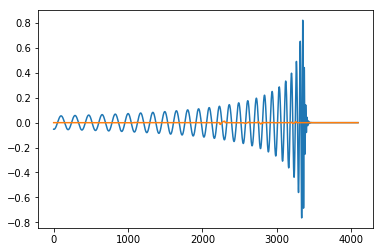

In [368]:
###
###  Test if it can produce an input GW signal
### 
for i in range(243,244):
    plt.figure()
    w0 = np.reshape( Xt[i], (-1, CH[0], RATE) )
    w1 = model_1.predict(w0)
    print (Yt[i,0],Yt[i,1])
    print (w1)
    print (w0.max(),w0.min())
    print (w1.max(),w1.min())
    plt.plot(w0[0,1,:])
    plt.plot(w1[0,1,:])
    plt.show()
    #plt.savefig("VAE_test1.png")

    #plt.figure()    
    #plt.plot(w1[0]-w0)
    #plt.savefig("VAE_test1diff.png")
    #plt.show()

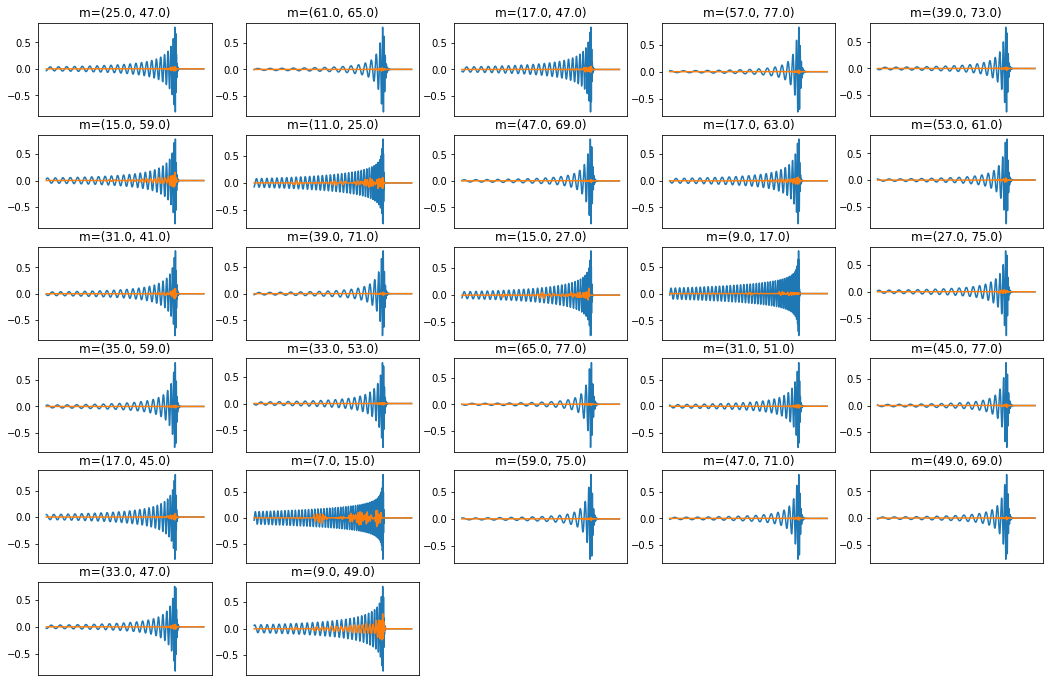

In [340]:
###  Test if it can produce many input GW signals

plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(Xt)), 30)   ## test randomly sample
w0 = np.reshape( Xt[ranidx], (-1, CH, RATE) )
w1 = model_1.predict(w0)

for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    
    plt.plot(w0[i,0,:])
    plt.plot(w1[i,0,:])
    plt.xticks([])
   
    if (i > 25): break
plt.show()
    
    
#plt.savefig("VAE_testdiff.png")

            
            
    

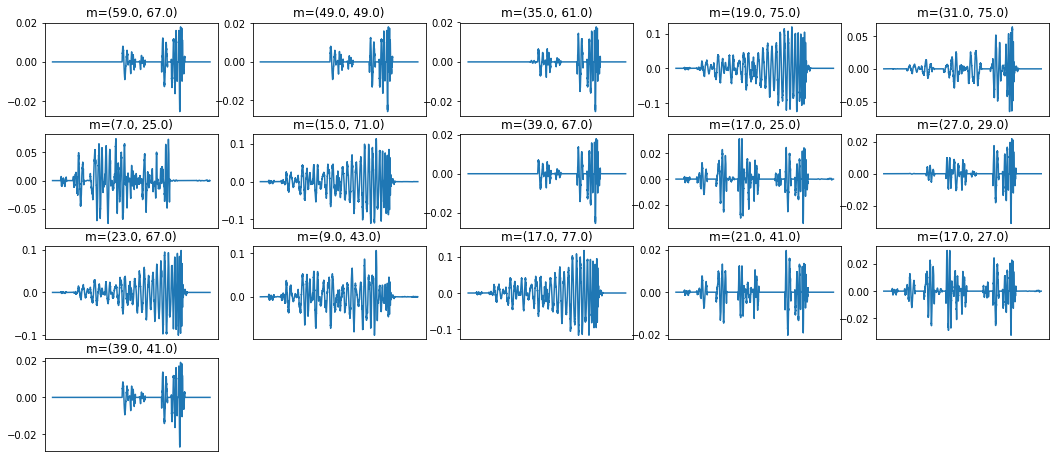

In [334]:
###  Generate from latent variables

plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(Xt)), 16)   ## test randomly sample
w0 = np.reshape( Xt[ranidx], (-1, CH, RATE) )
w1 = model_1.predict(w0)
wg = model_1.genwf(Yt[ranidx])
for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    plt.plot(wg[i,0,:])
    #plt.plot(w1[i]-wg[i])
    plt.xticks([])
    
    if (i > 25): break
plt.show()

 